<a href="https://colab.research.google.com/github/vivi1231/0814/blob/master/lymphoma_transferlearning_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
IMG_SIZE = 200
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

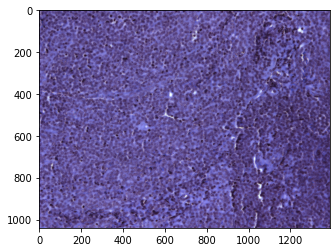

In [5]:
# Read single image
data_path = 'drive/My Drive/Day4/lymphoma/*/*.tif' 
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 20) # demo for 20 images
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1040, 1388, 3), (200, 200, 3))

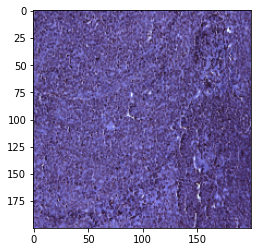

In [6]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [7]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/Day4/lymphoma/MCL/sj-05-901-R1_009.tif'

In [8]:
cls = img_path.split('/')[-2]
cls

'MCL'

In [9]:
class_map[cls]

1

In [10]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [11]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocess img
    # 前處理preprocess的function要follow前人，記得要一致!
    cls = path.split('/')[-2]
    
    X[i] = img
    y[i] = class_map[cls]

In [12]:
# label count
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0. 1. 2.] [9 2 9]


In [13]:
# One-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16, 200, 200, 3), (4, 200, 200, 3), (16, 3), (4, 3))

# Build Model

In [35]:
# clear graph
tf.keras.backend.clear_session()

In [23]:
# include_top=False 不要分類器
# 1: Transfer all layers
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(base_model.input, predictions)

In [19]:
# 凍結法 layer.trainable = False
# 2: Transfer all layers and freezing base model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x) #自己建的分類
x = Dense(1024, activation='relu')(x) #自己建的分類
predictions = Dense(3, activation='softmax')(x) #自己建的分類
model = Model(base_model.input, predictions)

for layer in base_model.layers:
    layer.trainable = False
    


In [20]:
# 3-1: Transfer 0 ~ 3 layers 只拿前面三層
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.layers[3].output
x = Conv2D(16, 3)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(base_model.input, predictions)


In [36]:
# 3-2: Transfer 0 ~ 4 layers by layer names
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.get_layer('activation').output
x = Conv2D(16, 3)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(base_model.input, predictions)


In [37]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 99, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 99, 32)        96        
_________________________________________________________________
activation (Activation)      (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 97, 97, 16)        4624      
_________________________________________________________________
global_average_pooling2d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)             

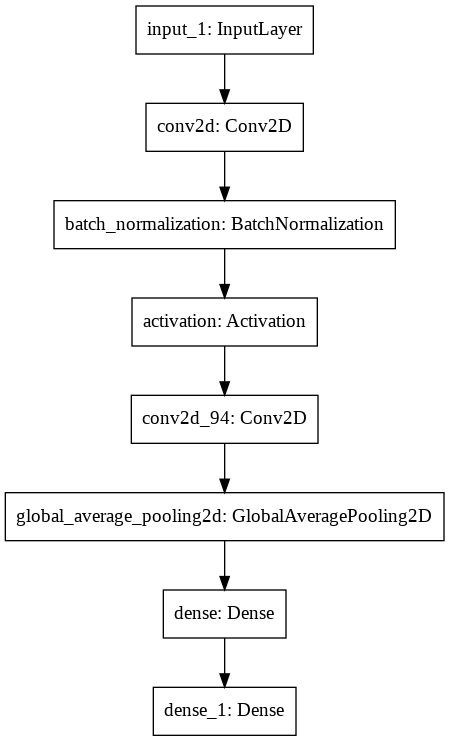

In [34]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [ ]:
logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=10,
                validation_data=(X_test, y_test))

In [ ]:
history = logs.history

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['acc', 'val_accuracy'])
plt.title('accuracy')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
